# Supplementary materials : Details on generating Figure 1

This document is a supplementary material of the article *Detecting periodicities with Gaussian
processes* by N. Durrande, J. Hensman, M. Rattray and N. D. Lawrence. 

The first step is to import the required packages. This tutorial has been written with GPy 0.8.8 which includes the kernels discussed in the article. The latter can be downloaded on the [SheffieldML github page](https://github.com/SheffieldML/GPy). 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

np.random.seed(1)

## Test functions

We now introduce 1-periodic tests functions that are defined over $[0,1)$ as:
\begin{equation}
	\begin{split}
	f_1(x)	& = \cos(2 \pi x) + \varepsilon\\
	f_2(x)	& = 1/2 \cos(2 \pi x) + 1/2 \cos(4 \pi x) + \varepsilon\\
	f_3(x)	& = \left\{
	\begin{matrix}
		1 + \varepsilon \text{    if } x \in [0,0.2]  \\
		-1 + \varepsilon \text{    if } x \in (0.2,1) \\
	\end{matrix}
	\right. \\
	f_4(x)	& = 4 |x-0.5| + 1) + \varepsilon\\
	f_5(x)	& = 1 - 2x + \varepsilon\\
	f_6(x)	& = + \varepsilon
	\end{split}
\end{equation}
where $\varepsilon$ is a $\mathcal{N}(0,\tau^2)$ random variable.

In [2]:
# domain boundaries
lower = 0.
upper = 3.
x = np.linspace(lower,upper,500)

# grid for function evaluations and plots
n_pts = 50
X = np.linspace(lower,upper,n_pts+1)
X = X[0:-1]+X[1]/2

# test functions
def f1(x,tau2=0.1):
    return(np.cos(x*2*np.pi) + np.sqrt(tau2)*np.random.normal(size=x.shape))

def f2(x,tau2=0.1):
    return(1./2*np.cos(x*2*np.pi)+1./2*np.cos(x*4*np.pi) + np.sqrt(tau2)*np.random.normal(size=x.shape))

def f3(x,tau2=0.1):
    alpha = 0.2
    return(2*(x - np.trunc(x) < alpha)-1 + np.sqrt(tau2)*np.random.normal(size=x.shape))

def f4(x,tau2=0.1):
    return(4*np.abs(x - np.trunc(x) - 0.5)-1 + np.sqrt(tau2)*np.random.normal(size=x.shape))

def f5(x,tau2=0.1):
    return(2*np.trunc(x) - 2*x +1 + np.sqrt(tau2)*np.random.normal(size=x.shape))

def f6(x,tau2=0.1):
    return(np.zeros((len(x),)) +  np.sqrt(tau2)*np.random.normal(size=x.shape))



The associated graphs are:

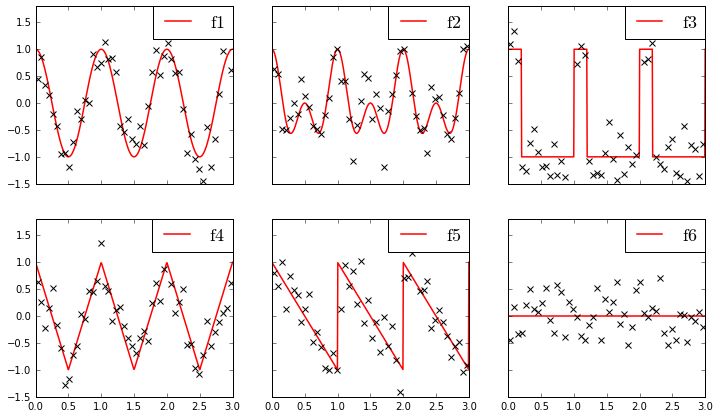

In [3]:
names = ['f1','f2','f3','f4','f5','f6']

fig, axs = plt.subplots(2,3,figsize=(12,7), sharex=True, sharey=True)
for i, (ax,testfunc) in enumerate(zip(axs.flat, [f1,f2,f3,f4,f5,f6])):
    ax.plot(x,testfunc(x,0.),'r', linewidth=1.5)
    ax.plot(X,testfunc(X),'kx',mew=1)
    ax.legend(['$\\mathrm{'+names[i]+'}$'],prop={'size':18},borderaxespad=0.)
    ax.set_ylim((-1.5,1.8))

## Models

**COSOPT:** We consider here the following implementation

In [4]:
def fit_cosopt(X,Y):
    X = X[:,None]
    Y = Y[:,None]
    period = np.linspace(0.15,2,100)
    phase = np.linspace(-np.pi,np.pi,100)

    MSE = np.zeros((100,100))
    for i,per in enumerate(period):
        for j,pha in enumerate(phase):
            B = np.hstack((np.ones(X.shape),np.cos(X*2*np.pi/per+pha)))
            C = np.dot(np.linalg.inv(np.dot(B.T,B)),np.dot(B.T,Y))
            MSE[i,j] = np.mean((np.dot(B,C)-Y)**2)

    i,j = np.unravel_index(MSE.argmin(), MSE.shape)
    B = np.hstack((np.ones(X.shape),np.cos(X*2*np.pi/period[i]+phase[j])))
    C = np.dot(np.linalg.inv(np.dot(B.T,B)),np.dot(B.T,Y))

    return((C,period[i],phase[j]))

def pred_cosopt(x,m_cosopt):
    C,per,pha = m_cosopt
    Bx = np.hstack((0*x[:,None]+1, np.cos(x[:,None]*2*np.pi/per+pha)))
    P = np.dot(Bx,C)
    return(P.flatten())


**Linear regression**

In [5]:
def B(x):
    # function returning the matrix of basis functions evaluated at x
    #input:   x, np.array with d columns
    #output:  a matrix (b_j(x_i))_{i,j}
    B = np.ones((x.shape[0],1))
    for i in range(1,20):
        B = np.hstack((B,np.sin(2*np.pi*i*x[:,None]),np.cos(2*np.pi*i*x[:,None])))
    return(B)

def LR(X,F,B,tau2):
    #input:   X, np.array with d columns representing the DoE
    #         F, np.array with 1 column representing the observations
    #         B, a function returning the (p) basis functions evaluated at x
    #         tau2, noise variance
    #output:  beta, estimate of coefficients np.array of shape (p,1)
    #         covBeta, cov matrix of beta, np.array of shape (p,p)
    BX = B(X)
    covBeta = np.linalg.inv(np.dot(BX.T,BX))
    beta = np.dot(covBeta,np.dot(BX.T,F))
    return(beta,tau2*covBeta)

def predLR(x,B,beta,covBeta):
    #function returning predicted mean and variance
    #input:   x, np.array with d columns representing m prediction points
    #         B, a function returning the (p) basis functions evaluated at x
    #         beta, estimate of the regression coefficients
    #         covBeta, covariance matrix of beta
    #output:  m, predicted mean at x, np.array of shape (m,1)
    #         v, predicted variance, np.array of shape (m,1)
    m = np.dot(B(x),beta)
    v = np.dot(B(x),np.dot(covBeta,B(x).T))
    return(m,v)


**Gaussian Process model**

In [6]:
def fit_gp(X,Y):
    #input:   X, np.array with d columns representing the DoE
    #         Y, np.array with 1 column representing the observations
    #output:  a GPy gaussian process model object
    X = X[:,None]
    Y = Y[:,None]
    k = GPy.kern.PeriodicMatern32(1,variance=1.,lengthscale=1., period=1., n_freq=20,lower=lower,upper=upper)
    bias = GPy.kern.Bias(1,variance=1.)
    m32 = GPy.models.GPRegression(X,Y,k+bias)
    m32.unconstrain('')                               # remove positivity constrains to avoids warnings
    m32.likelihood.constrain_bounded(0.001,3., warning=False)        # boundaries for the observation noise
    m32.kern.periodic_Matern32.constrain_bounded(0.01,3., warning=False)     # boundaries for the periodic variance and lengthscale 
    m32.kern.periodic_Matern32.period.constrain_bounded(0.15,2., warning=False)        # boundaries for the period
    m32.randomize()
    m32.optimize_restarts(5,robust=True)
    return(m32)

def pred_gp(x,m_gp):
    x = x[:,None]
    mu,var = m_gp.predict(x)
    return(mu.flatten())


Definition of the criterion for assesing the quality of a model prediction :

In [7]:
def RMSE(Ypred,Yreal):
    return( np.sqrt(np.mean((Yreal - Ypred)**2)) )

## Fit models

In [8]:
M_COS = []
M_GP  = []
M_LR  = []

for i,testfunc in enumerate([f1,f2,f3,f4,f5,f6]):
    Y = testfunc(X)
    Yreal  = testfunc(x,0)
    M_COS += [fit_cosopt(X,Y)]
    M_GP  += [fit_gp(X,Y)]
    M_LR  += [LR(X,Y,B,0.1)]

Optimization restart 1/5, f = 64.6381557382
Optimization restart 2/5, f = 20.1924219702
Optimization restart 3/5, f = 64.2805490956
Optimization restart 4/5, f = 64.638206481
Optimization restart 5/5, f = 64.6381544424
Optimization restart 1/5, f = 52.8350376662
Optimization restart 2/5, f = 29.5456094222
Optimization restart 3/5, f = 29.5453300529
Optimization restart 4/5, f = 45.9666595165
Optimization restart 5/5, f = 29.5453300116
Optimization restart 1/5, f = 62.9333515227
Optimization restart 2/5, f = 43.5915711551
Optimization restart 3/5, f = 45.4372991694
Optimization restart 4/5, f = 43.5915711609
Optimization restart 5/5, f = 43.5915711548
Optimization restart 1/5, f = 15.6691359207
Optimization restart 2/5, f = 15.6691357616
Optimization restart 3/5, f = 15.6691357416
Optimization restart 4/5, f = 23.0512998344
Optimization restart 5/5, f = 51.6129398693
Optimization restart 1/5, f = 31.676011619
Optimization restart 2/5, f = 46.6728376247
Optimization restart 3/5, f = 31.6

## Generate figure

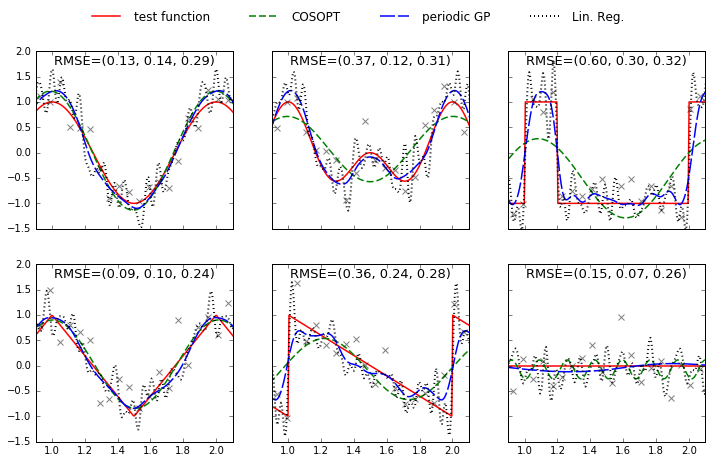

In [9]:
lower = 0.
upper = 3.
xRMSE = np.linspace(lower,upper,500)

fig, axes = plt.subplots(2,3,figsize=(12,7), sharex=True, sharey=True, tight_layout=False)
for i,testfunc in enumerate([f1,f2,f3,f4,f5,f6]):
    Y = testfunc(X)
    Yreal = testfunc(x,0)
    ax = axes.flat[i]
    # test func
    plreal, = ax.plot(x,Yreal, '-r', linewidth=1.5,label="test function")
    realRMSE = testfunc(xRMSE,0)
    # COSOPT
    cosopt_pred = pred_cosopt(x,M_COS[i])
    plcos, = ax.plot(x,cosopt_pred, '--g', linewidth=1.5,label="COSOPT", dashes=(7,3))
    cRMSE = RMSE(pred_cosopt(xRMSE,M_COS[i]),realRMSE)
    #GP 32
    gp_pred = pred_gp(x,M_GP[i])
    plgp, = ax.plot(x,gp_pred, '--b', linewidth=1.5,label="periodic GP", dashes=(15,3))
    gpRMSE = RMSE(pred_gp(xRMSE,M_GP[i]),realRMSE)
    # Lin Reg
    lr_pred = predLR(x,B,M_LR[i][0],M_LR[i][1])
    pllr, = ax.plot(x,lr_pred[0], ':k', linewidth=2,label="periodic GP")
    lrRMSE = RMSE(predLR(xRMSE,B,M_LR[i][0],M_LR[i][1])[0],realRMSE)
    #
    ax.plot(X,testfunc(X),'kx',mew=1, alpha=0.5)
    ax.set_xlim((0.9,2.1))
    ax.set_ylim((-1.5,2.))
    ## RMSE
    ax.text(1.5, 1.8, 'RMSE=(%.2f, %.2f, %.2f)'%(cRMSE,gpRMSE,lrRMSE),
        verticalalignment='center', horizontalalignment='center', fontsize=13)

fig.suptitle('  ')
l = fig.legend((plreal,plcos,plgp,pllr),("test function","COSOPT","periodic GP","Lin. Reg."),'upper center',ncol=4,handlelength=3,fancybox=True,columnspacing=3)
l.draw_frame(False)

